### NPSC psudeo-extension stands for NuPlan Scenario Collection. 
#### It is a pkl file with the naming convention `filename.npsc.pkl` that contains:
* The data structure of a dictionary of scenario modifications.
* The `DATASET_PARAMS` list of filters in order to extract the correct scenarios to modify.

In [1]:
import logging
import random
import nest_asyncio
import pandas as pd

nest_asyncio.apply()

import torch

torch.cuda.is_available()

import os
from pathlib import Path
import tempfile

from shutil import rmtree
from typing import List, Optional, Union

from nuplan.planning.script.run_simulation import main as main_simulation

In [2]:
%env NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
%env NUPLAN_MAPS_ROOT=../../data/nuplan/maps
%env NUPLAN_EXP_ROOT=../../data/nuplan/exp
%env NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/
%pwd

env: NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
env: NUPLAN_MAPS_ROOT=../../data/nuplan/maps
env: NUPLAN_EXP_ROOT=../../data/nuplan/exp
env: NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/


'/home/ehdykhne/nuplan-devkit/experiments'

In [3]:
import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf

from nuplan.common.utils.s3_utils import is_s3_path
from nuplan.planning.script.builders.simulation_builder import build_simulations
from nuplan.planning.script.builders.simulation_callback_builder import (
    build_callbacks_worker,
    build_simulation_callbacks,
)
from nuplan.planning.script.utils import (
    run_runners,
    set_default_path,
    set_up_common_builder,
)
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# If set, use the env. variable to overwrite the default dataset and experiment paths
set_default_path()

# If set, use the env. variable to overwrite the Hydra config
CONFIG_PATH = os.getenv("NUPLAN_HYDRA_CONFIG_PATH", "config/simulation")

if os.environ.get("NUPLAN_HYDRA_CONFIG_PATH") is not None:
    CONFIG_PATH = os.path.join("../../../../", CONFIG_PATH)

if os.path.basename(CONFIG_PATH) != "simulation":
    CONFIG_PATH = os.path.join(CONFIG_PATH, "simulation")
CONFIG_NAME = "default_simulation"

In [4]:
from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths

# Location of paths with all simulation configs
BASE_CONFIG_PATH = os.path.join(
    os.getenv("NUPLAN_TUTORIAL_PATH", ""), "../nuplan/planning/script"
)
simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

In [5]:
import pickle
#pdm_closed_pdm_closed_cross_pure_scen_20
#pdm_closed_pdm_closed_seq_pure_scen_100
#pdm_closed_pdm_closed_merge_pure_scen_20
#pdm_closed_pdm_closed_diverge_pure_scen_1400
EXPERIMENT_NAME = "pdm_closed_pdm_closed_diverge_pure_scen_1400"
modification_file_path = "npsc_files/" + EXPERIMENT_NAME + ".npsc.pkl"
with open(modification_file_path, "rb") as output_file:
    mod_list_dict = pickle.load(output_file)
    print(list(mod_list_dict.keys()))
    DATASET_PARAMS = pickle.load(output_file)

print(DATASET_PARAMS)

['ea29f4aa6dd2598c', 'b0646a16830258a6', 'ec5653d7ba5a5464', 'c6492065deb75fa1', '694b93d17f1355be', '17a1b01f3ae45487']
['scenario_builder=val', 'scenario_filter=all_scenarios', "scenario_filter.scenario_types=['starting_left_turn', 'starting_right_turn', 'starting_straight_stop_sign_intersection_traversal', 'starting_straight_traffic_light_intersection_traversal', 'starting_unprotected_cross_turn', 'starting_unprotected_noncross_turn', 'traversing_intersection', 'traversing_traffic_light_intersection']", 'scenario_filter.ego_displacement_minimum_m=10', 'scenario_filter.map_names=[sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]', 'scenario_filter.num_scenarios_per_type=1400']


In [6]:
urban_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt"
gc_pgp_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/gc_pgp_checkpoint.ckpt"
hybrid_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/pdm_offset_checkpoint.ckpt"
#'/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
#'/home/ehdykhne/Repos/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'

In [7]:
# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)

# Compose the configuration
print(simulation_hydra_paths.config_name)
cfg_occ = hydra.compose(
    config_name=simulation_hydra_paths.config_name,
    overrides=[
        # planner
        ################################################
        "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
        # planner occlusion
        ################################################
        "+occlusion_cfg.occlusion=true",
        "+occlusion_cfg.manager_type=wedge",  # options: [range, shadow, wedge]
        "+occlusion_cfg.uncloak_reaction_time=1.5",
        "+occlusion_cfg.notice_threshold=1.0",
        ################################################
        # obs
        ################################################
        f"observation.planner_type=pdm_closed",
        ################################################
        # obs occlusion
        ################################################
        f"observation.occlusion_cfg.occlusion=True",
        f"observation.occlusion_cfg.manager_type=wedge",
        f"+observation.occlusion_cfg.uncloak_reaction_time=1.5",
        f"+observation.occlusion_cfg.notice_threshold=1.0",
        ################################################
        # scenario modification
        "+modify_scenario_simulations=true",
        "+second_testing_round=true",
        f"+modification_file_path={modification_file_path}",
        # "+remove_other_agents=true",
        ################################################
        # misc
        ################################################
        "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
        "worker=ray_distributed",  # [sequential, ray_distributed]
        "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
        *DATASET_PARAMS,
        ################################################
    ],
)

output_folder_occ = cfg_occ.output_dir
print('output_folder_occ = "' + output_folder_occ + '"')

default_simulation
output_folder_occ = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.07.20.07.05.49"


### Now, we run the simulations

In [8]:
# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg_occ)

Global seed set to 0
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback...
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback: 4...DONE!


2024-07-20 07:05:50,084 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2024-07-20 07:05:50,121 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2024-07-20 07:05:51,761	INFO worker.py:1636 -- Started a local Ray instance.


2024-07-20 07:05:52,409 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2024-07-20 07:05:52,409 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 32
Number of GPUs per node: 4
Number of threads across all nodes: 32
2024-07-20 07:05:52,410 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2024-07-20 07:05:52,410 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2024-07-20 07:05:52,410 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.07.20.07.05.49

2024-07-20 07:05:52,412 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_build

Ray objects: 100%|██████████| 32/32 [00:07<00:00,  4.10it/s]
(raylet) [2024-07-20 07:06:01,737 E 1583374 1583386] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-20_07-05-50_177998_1583182 is over 95% full, available space: 75357753344; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-07-20 07:06:11,741 E 1583374 1583386] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-20_07-05-50_177998_1583182 is over 95% full, available space: 75361181696; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-07-20 07:06:21,744 E 1583374 1583386] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-20_07-05-50_177998_1583182 is over 95% full, available space: 75361177600; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-07-20 07:06:31,748 E 1583374 1583386] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-20_07-05-50_177998_1583

2024-07-20 07:09:31,637 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:84}  Building metric engines...
2024-07-20 07:09:31,787 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:86}  Building metric engines...DONE
2024-07-20 07:09:31,787 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:90}  Building simulations from 8789 scenarios...


(raylet) [2024-07-20 07:09:31,788 E 1583374 1583386] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-20_07-05-50_177998_1583182 is over 95% full, available space: 75360751616; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-07-20 07:09:41,790 E 1583374 1583386] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-20_07-05-50_177998_1583182 is over 95% full, available space: 75360743424; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-07-20 07:09:51,794 E 1583374 1583386] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-20_07-05-50_177998_1583182 is over 95% full, available space: 75360702464; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-07-20 07:10:01,797 E 1583374 1583386] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-20_07-05-50_177998_1583182 is over 95% full, available space: 75360681984; capacity:

# original intersection ids 8625
# unique original intersection ids 405
unique original intersection ids ['45267', '46960', '17602', '17624', '17685', '60017', '47025', '59672', '59683', '17615', '47051', '60130', '47093', '17635', '60203', '17608', '59507', '59700', '45362', '17668', '59664', '46932', '59712', '46923', '59705', '60117', '47148', '17626', '45280', '17603', '17607', '47147', '59615', '46985', '59655', '17667', '59657', '47150', '45162', '17589', '17599', '60185', '17678', '47132', '47160', '60173', '60104', '17625', '59534', '17583', '17597', '17684', '47035', '47119', '47082', '47060', '47120', '17620', '59543', '46981', '46938', '47081', '47049', '17631', '59623', '59680', '47019', '60232', '45168', '45203', '47103', '59686', '45228', '45218', '47050', '17614', '60161', '60246', '47122', '45192', '59645', '59600', '45478', '45365', '59710', '59646', '59639', '46958', '46970', '47074', '45220', '45249', '59682', '45449', '60264', '59643', '59722', '45411', '47116', '46

(raylet) [2024-07-20 07:15:41,889 E 1583374 1583386] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-20_07-05-50_177998_1583182 is over 95% full, available space: 75359866880; capacity: 16125711347712. Object creation will fail if spilling is required.


[
	'17a1b01f3ae45487',
	'694b93d17f1355be',
	'b0646a16830258a6',
	'c6492065deb75fa1',
	'ea29f4aa6dd2598c',
	'ec5653d7ba5a5464'
]
2024-07-20 07:15:42,076 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:231}  Created 7 modified scenarios from 8789 scenarios, 6 of which were modifiable.
2024-07-20 07:15:42,076 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:232}  Building simulations...DONE!
2024-07-20 07:15:42,106 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:113}  Running simulation...
2024-07-20 07:15:42,106 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:138}  Executing runners...
2024-07-20 07:15:42,107 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:82}  Starting 7 simulations using RayDistributed!


Ray objects:   0%|          | 0/7 [00:00<?, ?it/s](raylet) [2024-07-20 07:15:51,894 E 1583374 1583386] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-20_07-05-50_177998_1583182 is over 95% full, available space: 75359772672; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-07-20 07:16:01,898 E 1583374 1583386] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-20_07-05-50_177998_1583182 is over 95% full, available space: 75359764480; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-07-20 07:16:11,903 E 1583374 1583386] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-20_07-05-50_177998_1583182 is over 95% full, available space: 75359764480; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-07-20 07:16:21,908 E 1583374 1583386] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-20_07-05-50_177998_1583182 is over

2024-07-20 07:16:44,121 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:129}  Number of successful simulations: 7
2024-07-20 07:16:44,121 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:130}  Number of failed simulations: 0
2024-07-20 07:16:44,121 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2024-07-20 07:16:44,128 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.07.20.07.05.49/runner_report.parquet
2024-07-20 07:16:44,128 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:10:54 [HH:MM:SS]
2024-07-20 07:16:44,275 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:79}  Metric files integration: 00:00:00 [HH:MM:SS]
2024-07-20 07:16:44,342 I

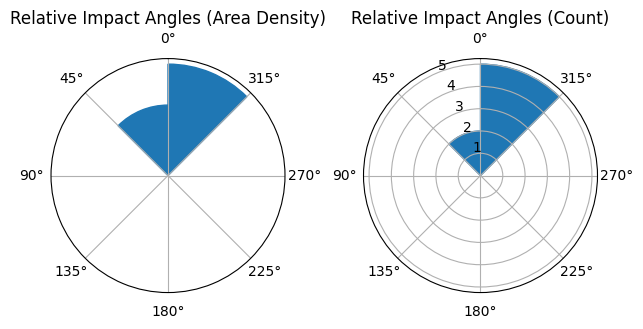

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from vis_utils import circular_hist

%matplotlib inline

#seq
#output_folder_occ = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.07.12.02.10.00"

#cross
#output_folder_occ = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.07.20.06.07.54"

#merge
#output_folder_occ = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.07.20.06.04.14"

#diverge
#output_folder_occ = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.07.20.06.02.15

file_path = output_folder_occ + "/metrics/" + "no_ego_at_fault_collisions.parquet"
df = pd.read_parquet(file_path)
relative_angles_of_impact_df = df[
    "relative_impact_angle_at_first_ego_collision_with_vehicles_stat_value"
]
relative_angles_of_impact = relative_angles_of_impact_df.to_numpy()

# fig, ax = plt.subplots(1, 2)
# fig.tight_layout()
figp, axp = plt.subplots(1, 2, subplot_kw=dict(projection="polar"))
figp.tight_layout()

# Visualise by area of bins
circular_hist(
    axp[0],
    relative_angles_of_impact,
    bins=8,
    density=True,
    offset=np.pi / 2,
    gaps=False,
)

circular_hist(
    axp[1],
    relative_angles_of_impact,
    bins=8,
    density=False,
    offset=np.pi / 2,
    gaps=False,
)


axp[0].title.set_text("Relative Impact Angles (Area Density)")
axp[1].title.set_text("Relative Impact Angles (Count)")

2024-07-20 07:16:45,272 WARNING {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/legend.py:1363}  No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-07-20 07:16:45,273 WARNING {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/matplotlib/legend.py:1363}  No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Severity Class')

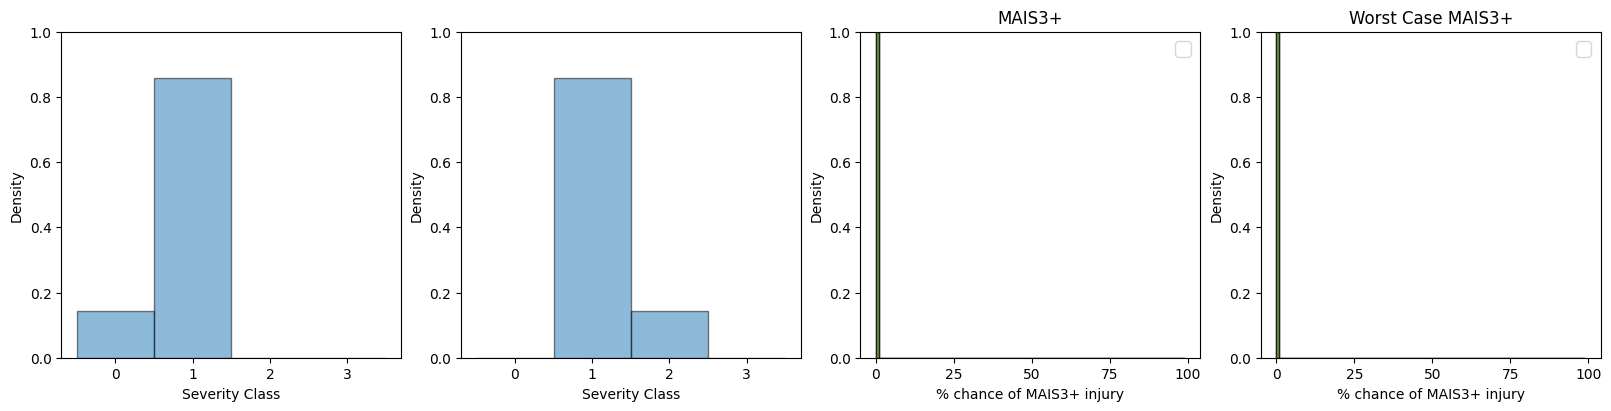

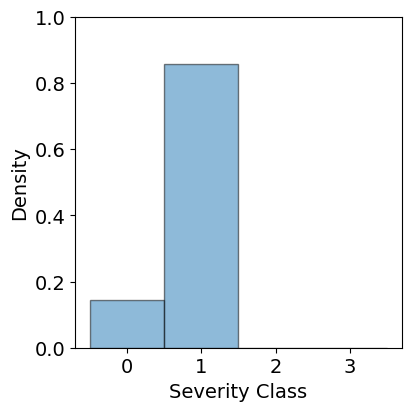

In [10]:
df = pd.read_parquet(file_path)
severity_class_df = df[
    "severity_class_at_first_ego_collision_with_vehicles_stat_value"
]
severity_class = severity_class_df.to_numpy()

wc_severity_class_df = df[
    "severity_class_worst_case_at_first_ego_collision_with_vehicles_stat_value"
]
wc_severity_class = wc_severity_class_df.to_numpy()

mais3_driver_df = df[
    "mais3+_driver_at_first_ego_collision_with_vehicles_stat_value"
]
mais3_driver = mais3_driver_df.to_numpy()

mais3_passenger_df = df[
    "mais3+_passenger_at_first_ego_collision_with_vehicles_stat_value"
]
mais3_passenger = mais3_passenger_df.to_numpy()

mais3_backseat_df = df[
    "mais3+_backseat_at_first_ego_collision_with_vehicles_stat_value"
]
mais3_backseat = mais3_backseat_df.to_numpy()

wc_mais3_driver_df = df[
    "mais3+_worst_case_driver_at_first_ego_collision_with_vehicles_stat_value"
]
wc_mais3_driver = wc_mais3_driver_df.to_numpy()

wc_mais3_passenger_df = df[
    "mais3+_worst_case_passenger_at_first_ego_collision_with_vehicles_stat_value"
]
wc_mais3_passenger = wc_mais3_passenger_df.to_numpy()

wc_mais3_backseat_df = df[
    "mais3+_worst_case_backseat_at_first_ego_collision_with_vehicles_stat_value"
]
wc_mais3_backseat = wc_mais3_backseat_df.to_numpy()



fig, ax = plt.subplots(1, 4, figsize=(16, 4), constrained_layout=True)
#fig.tight_layout(pad=5)

plt.rcParams.update({'font.size': 14})

xticks = [0, 1, 2, 3]

for a in ax:
        a.set_ylim([0, 1])

ax[0].hist(severity_class, density=True, bins=np.arange(-1,4)+0.5, ec="k", alpha=0.5, range=(-0.5, 3.5))
ax[0].set_xticks(xticks)

ax[1].hist(wc_severity_class, density=True, bins=np.arange(-1,4)+0.5, ec="k", alpha=0.5, range=(-0.5, 3.5))
ax[1].set_xticks(xticks)

bins = np.arange(0, 100, 1)
ax[2].hist(mais3_backseat, bins=bins, density=True, ec="k", alpha=0.5)
ax[2].hist(mais3_passenger, bins=bins, density=True, ec="k", alpha=0.5)
ax[2].hist(mais3_driver, bins=bins, density=True, ec="k", alpha=0.5)

ax[3].hist(wc_mais3_backseat, bins=bins, density=True, ec="k", alpha=0.5)
ax[3].hist(wc_mais3_passenger, bins=bins, density=True, ec="k", alpha=0.5)
ax[3].hist(wc_mais3_driver, bins=bins, density=True, ec="k", alpha=0.5)




# ax[0].title.set_text("Severity Class")
ax[0].yaxis.set_label_text("Density")
ax[0].xaxis.set_label_text("Severity Class")
# ax[1].title.set_text("Worst Case Severity Class")
ax[1].yaxis.set_label_text("Density")
ax[1].xaxis.set_label_text("Severity Class")
ax[2].title.set_text("MAIS3+")
ax[2].yaxis.set_label_text("Density")
ax[2].legend(loc='upper right')
ax[2].xaxis.set_label_text("% chance of MAIS3+ injury")
ax[3].title.set_text("Worst Case MAIS3+")
ax[3].yaxis.set_label_text("Density")
ax[3].xaxis.set_label_text("% chance of MAIS3+ injury")
ax[3].legend(loc='upper right')

# fig.get_layout_engine().set(wspace=0)


fig, ax = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
#fig.tight_layout(pad=5)

plt.rcParams.update({'font.size': 14})

xticks = [0, 1, 2, 3]

ax.set_ylim([0, 1])

ax.hist(severity_class, density=True, bins=np.arange(-1,4)+0.5, ec="k", alpha=0.5, range=(-0.5, 3.5))
ax.set_xticks(xticks)


# ax[0].title.set_text("Severity Class")
ax.yaxis.set_label_text("Density")
ax.xaxis.set_label_text("Severity Class")







/tmp/ipykernel_3862116/2575794345.py:44: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for l in lgnd.legendHandles:


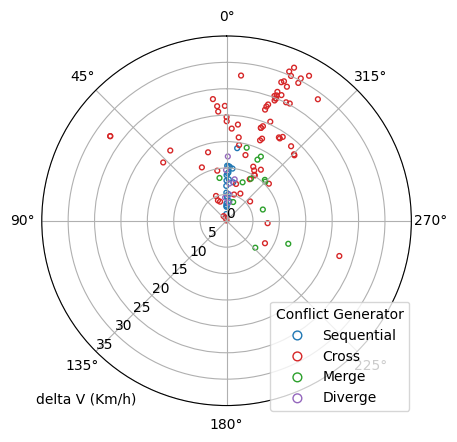

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#########################################
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
folder = []
#seq
folder.append("../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.07.12.02.10.00")
#cross
folder.append("../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.07.20.06.07.54")
#merge
folder.append("../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.07.20.06.04.14")
#diverge
folder.append("../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.07.20.07.05.49")

plt.rcParams.update({'font.size': 10})

colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:purple']
for i, f in enumerate(folder):
    file_path = f + "/metrics/" + "no_ego_at_fault_collisions.parquet"
    df = pd.read_parquet(file_path)

    dv = df[
        "first_ego_collision_energy_with_vehicles_stat_value"
    ]
    dv = dv.to_numpy() * 3.6

    impact_angle = df[
        "relative_impact_angle_at_first_ego_collision_with_vehicles_stat_value"
    ]
    theta = impact_angle.to_numpy()
    ax.set_theta_offset(np.pi / 2)
    ax.scatter(theta, dv, facecolors='none', edgecolors=colors[i], s=12)


ax.set_rmax(35)
ax.set_rticks(range(0, 40, 5))  # Less radial ticks
ax.set_rlabel_position(180-45)  # Move radial labels away from plotted lin
ax.grid(True)

lgnd = ax.legend(['Sequential', 'Cross', 'Merge', 'Diverge'], loc='upper left', bbox_to_anchor=(0.6, 0.3), title="Conflict Generator")
#change the marker size manually for both lines
for l in lgnd.legendHandles:
    l._sizes = [40]

# ax.set_title("Radial Plot of Impact Angles and Delta V", va='bottom')
ax.set_ylabel('delta V (Km/h)', rotation=0, size=10, loc='bottom')
plt.show()


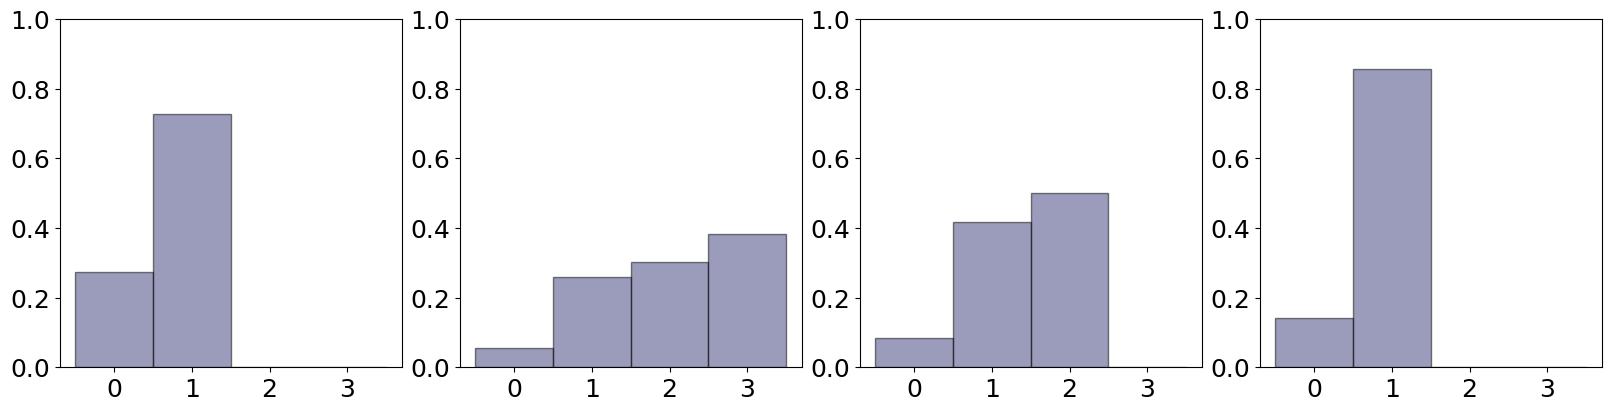

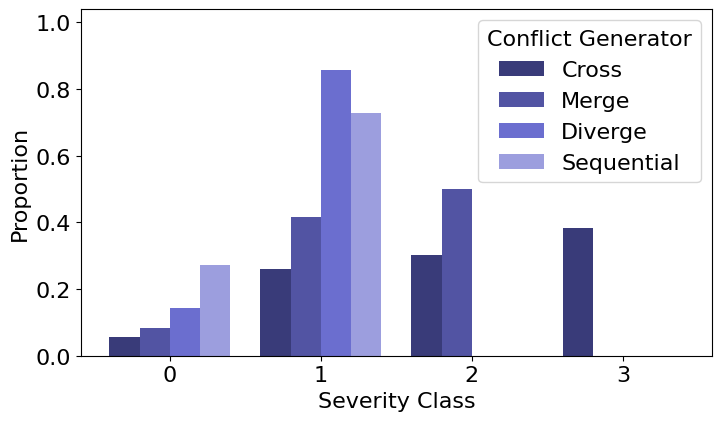

In [49]:
from matplotlib import cycler,colormaps

fig, ax = plt.subplots(1, 4, figsize=(16, 4), constrained_layout=True)
#fig.tight_layout(pad=5)

plt.rcParams.update({'font.size': 14})

xticks = [0, 1, 2, 3]

h = []

for i, f in enumerate(folder):
    file_path = f + "/metrics/" + "no_ego_at_fault_collisions.parquet"
    df = pd.read_parquet(file_path)

    impact_angle = df[
        "relative_impact_angle_at_first_ego_collision_with_vehicles_stat_value"
    ]
    severity_class_df = df[
        "severity_class_at_first_ego_collision_with_vehicles_stat_value"
    ]
    severity_class = severity_class_df.to_numpy()
    ax[i].set_ylim([0, 1])
    n, _, _ = ax[i].hist(severity_class, density=True, bins=np.arange(-1,4)+0.5, ec="k", alpha=0.5, range=(-0.5, 3.5))
    h.append(n)


plt.rcParams.update({'font.size': 16})
seq = h[0]
cross = h[1]
merge = h[2]
div = h[3]
sev = np.arange(4)

plt.figure(figsize=(7.5,4.5),layout='tight')
plt.rcParams['axes.prop_cycle']=cycler(color=colormaps['tab20b'].colors)
for i,(dens,lab) in enumerate(zip([cross,merge,div,seq],['Cross','Merge','Diverge','Sequential'])):
    plt.bar(sev+i/5,dens,width=0.2,label=lab)
plt.legend(title='Conflict Generator')
plt.ylim(0,1.04)
plt.xticks(sev+0.3,sev)
plt.xlabel('Severity Class')
plt.ylabel('Proportion')
plt.set_cmap('Blues')
plt.savefig('OCC_distributions.pdf',bbox_inches='tight',pad_inches=0.01)
plt.show()

In [12]:
path = output_folder_occ + "/metrics/"
file_path_1 = path + "no_ego_at_fault_collisions.parquet"
df = pd.read_parquet(file_path_1)
df = df.loc[df["number_of_ego_collisions_with_vehicles_stat_value"] != 0]
df = df["scenario_name"]


scenario_list = df.tolist()
print("num : ", len(scenario_list))
for item in scenario_list:
    print(item)

num :  7
ea29f4aa6dd2598c_diverge_conflict_injection_and_occlusion_injection_053522
b0646a16830258a6_diverge_conflict_injection_and_occlusion_injection_046898
ec5653d7ba5a5464_diverge_conflict_injection_and_occlusion_injection_053410
c6492065deb75fa1_diverge_conflict_injection_and_occlusion_injection_053029
694b93d17f1355be_diverge_conflict_injection_and_occlusion_injection_153139
17a1b01f3ae45487_diverge_conflict_injection_and_occlusion_injection_053522
694b93d17f1355be_diverge_conflict_injection_and_occlusion_injection_053139


In [13]:
import re

output_folder = [output_folder_occ]

print(output_folder_occ)

CONFIG_PATH = "../nuplan/planning/script/config/nuboard"
CONFIG_NAME = "default_nuboard"

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)
scenario_builder = None
for item in DATASET_PARAMS:
    parts = re.split("=", item, 1)
    if parts[0] == "scenario_builder":
        scenario_builder = parts[1]
if scenario_builder is None:
    raise ValueError("scenario_builder not specified in the dataset parameters")
print(scenario_builder)
# Compose the configuration
cfg = hydra.compose(
    config_name=CONFIG_NAME,
    overrides=[
        f"scenario_builder={scenario_builder}",  # set the database (same as simulation) used to fetch data for visualization
        f"simulation_path={output_folder}",  # [output_folder, output_folder_alt] nuboard file path(s), if left empty the user can open the file inside nuBoard
    ],
)

../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.07.20.07.05.49
val


### Launch NuBoard

In [14]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

2024-07-20 07:16:46,534 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2024-07-20 07:16:46,552 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2024-07-20 07:16:46,553 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2024-07-20 07:16:46,553 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:85}  Async rendering is set to: True
2024-07-20 07:16:46,553 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/server.py:403}  Starting Bokeh server version 2.4.3 (running on Tornado 6.3.3)
2024-07-20 07:16:46,553 WARNING {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/util.py:145}  Host wildcard '*' will allow connections originating from multiple (or possib

INFO:tornado.access:200 GET / (127.0.0.1) 235.43ms


2024-07-20 07:16:47,675 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  101 GET /ws (127.0.0.1) 0.51ms
2024-07-20 07:16:47,675 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:132}  WebSocket connection opened
2024-07-20 07:16:47,676 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:213}  ServerConnection created


INFO:tornado.access:101 GET /ws (127.0.0.1) 0.51ms
(raylet) [2024-07-20 07:16:51,918 E 1583374 1583386] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-20_07-05-50_177998_1583182 is over 95% full, available space: 75256471552; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-07-20 07:17:01,920 E 1583374 1583386] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-20_07-05-50_177998_1583182 is over 95% full, available space: 75256336384; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-07-20 07:17:11,923 E 1583374 1583386] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-20_07-05-50_177998_1583182 is over 95% full, available space: 75256328192; capacity: 16125711347712. Object creation will fail if spilling is required.


KeyboardInterrupt: 

(raylet) [2024-07-20 07:17:21,925 E 1583374 1583386] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-07-20_07-05-50_177998_1583182 is over 95% full, available space: 75256324096; capacity: 16125711347712. Object creation will fail if spilling is required.
